# Preprocessing and clustering 3k PBMCs

In May 2017, this started out as a demonstration that Scanpy would allow to reproduce most of Seurat's ([Satija et al., 2015](https://doi.org/10.1038/nbt.3192)) [guided clustering tutorial](http://satijalab.org/seurat/pbmc3k_tutorial.html). We gratefully acknowledge the authors of Seurat for the tutorial. In the meanwhile, we have added and removed a few pieces.  
    
The data consists in *3k PBMCs from a Healthy Donor* and is freely available from 10x Genomics ([here](http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz) from this [webpage](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/pbmc3k)). On a unix system, you can uncomment and run the following to download and unpack the data

In [ ]:
# !mkdir data
# !wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
# !cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz

<div class="alert alert-info">

**Note**
    
Download the notebook by clicking on the _Edit on GitHub_ button. On GitHub, you can download using the _Raw_ button via right-click and _Save Link As_. Alternatively, download the whole [scanpy-tutorial](https://github.com/theislab/scanpy-tutorials) repository.

</div>  

<div class="alert alert-info">

**Note**
    
In Jupyter notebooks and lab, you can see the documentation for a python function by hitting ``SHIFT + TAB``. Hit it twice to expand the view.

</div>

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scipy as sp
import matplotlib.pyplot as plt
from bioinfokit import visuz

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)

scanpy==1.4.5.2.dev11+gbe1a0555 anndata==0.7.1 umap==0.3.10 numpy==1.17.0 scipy==1.4.1 pandas==0.25.1 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1


In [3]:
results_file = '/Users/student/Desktop/BP205B/HCC_MK/write/hccmk.h5ad'  # the file that will store the analysis results

Actually do the filtering.

Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.

Scale each gene to unit variance. Clip values exceeding standard deviation 10. 

In [4]:
adata = sc.read("/Users/student/Desktop/BP205B/processed/HCC_MK_normalized_adata.h5ad")

In [5]:
sc.pp.filter_genes(adata, min_counts=1)

filtered out 287 genes that are detected in less than 1 counts


In [7]:
adata.raw= adata

## Regress out cell cycle genes

In [9]:
import urllib.request
cell_cycle_genes = [x.strip().decode('utf-8') for x in urllib.request.urlopen('https://raw.githubusercontent.com/theislab/scanpy_usage/master/180209_cell_cycle/data/regev_lab_cell_cycle_genes.txt')]
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]


In [10]:
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs) (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs) (0:00:00)
-->     'phase', cell cycle phase (adata.obs)


computing PCA with n_comps = 50
    finished (0:00:00)


... storing 'phase' as categorical


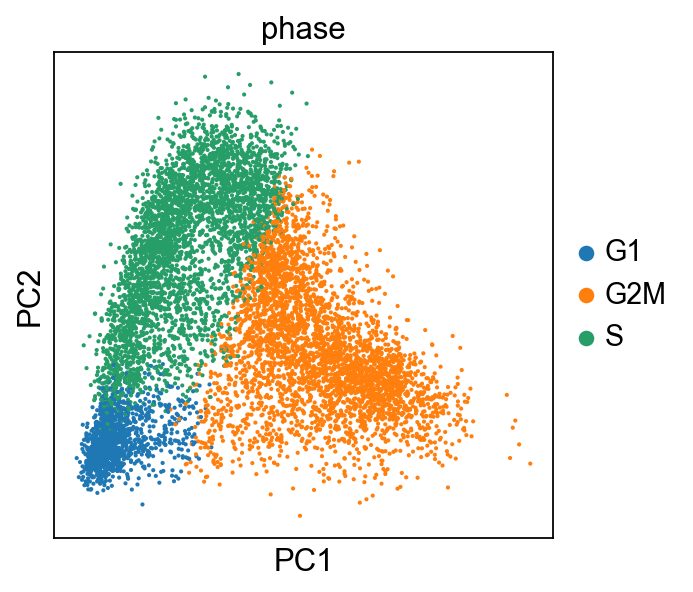

In [11]:
adata_cc_genes = adata[:, cell_cycle_genes]
sc.tl.pca(adata_cc_genes)
sc.pl.pca_scatter(adata_cc_genes, color='phase')


In [12]:
sc.pp.regress_out(adata, ['S_score', 'G2M_score'])
sc.pp.scale(adata)

regressing out ['S_score', 'G2M_score']
    sparse input is densified and may lead to high memory use


... storing 'phase' as categorical


    finished (0:02:55)


computing PCA with n_comps = 50
    finished (0:00:00)


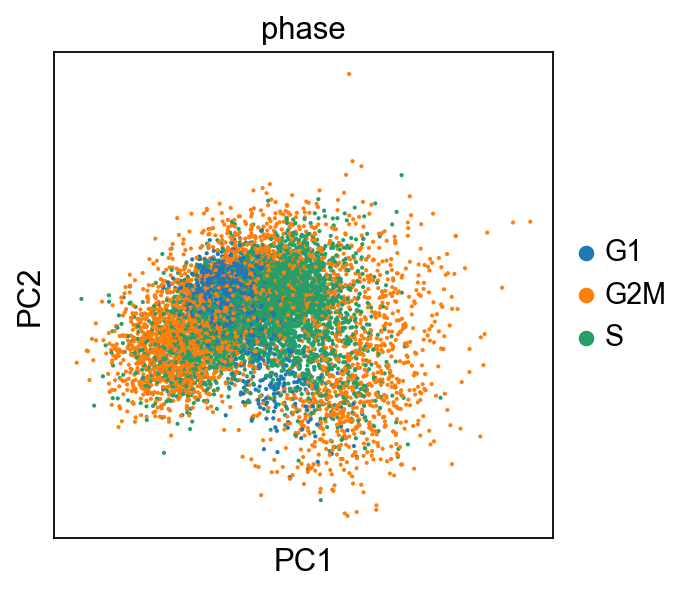

In [13]:
adata_cc_genes = adata[:, cell_cycle_genes]
sc.tl.pca(adata_cc_genes)
sc.pl.pca_scatter(adata_cc_genes, color='phase')

## Principal component analysis

Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.

In [15]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA with n_comps = 50
    finished (0:00:17)


We can make a scatter plot in the PCA coordinates, but we will not use that later on.

Let us inspect the contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function  `sc.tl.louvain()` or tSNE `sc.tl.tsne()`. In our experience, often, a rough estimate of the number of PCs does fine.

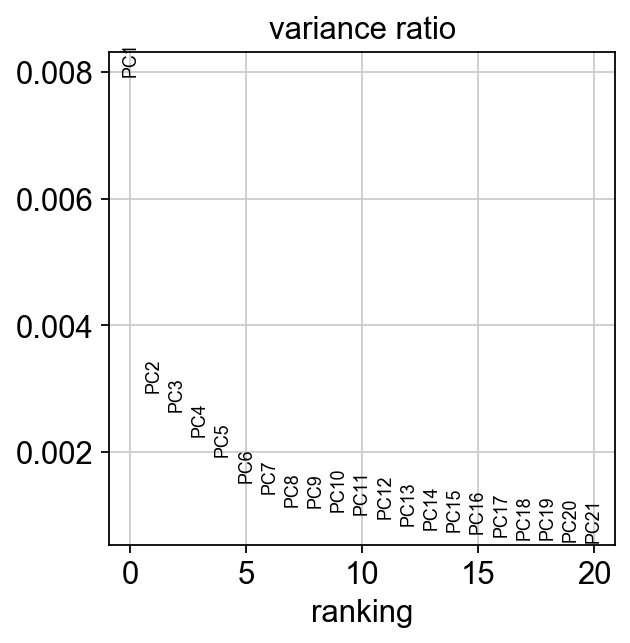

In [17]:
sc.pl.pca_variance_ratio(adata, log=False,n_pcs = 20)

Save the result.

In [18]:
adata.write(results_file)

## Computing the neighborhood graph and UMAP

Let us compute the neighborhood graph of cells using the PCA representation of the data matrix. You might simply use default values here. For the sake of reproducing Seurat's results, let's take the following values.

In [19]:
sc.pp.neighbors(adata, n_neighbors=15, knn = True, n_pcs=13)

computing neighbors
    using 'X_pca' with n_pcs = 13


/usr/local/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../usr/local/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/usr/local/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../usr/local/lib/python3.7/site-packages/umap/utils.py", line 409:
@

    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:07)


In [20]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:12)


## Classification according to neighbourhood graphs

In [21]:
LM_percent = []
Parental_percent = []
mask = []
for i in range(0,len(adata)):
    if adata.obs.iloc[i]['SampleType'] == "parental":
        neighbours = adata.obs[adata.uns['neighbors']['distances'].toarray()[i]!=0]
        num_LM = len(neighbours[neighbours['SampleType'] != "parental"])
        LM_percent.append(num_LM/14.0)
        if num_LM/14.0 >= 0.5:
            mask.append("p-H")
        else:
            mask.append("p-L")
    else:
        neighbours = adata.obs[adata.uns['neighbors']['distances'].toarray()[i]!=0]
        num_parental = len(neighbours[neighbours['SampleType'] != "parental"])
        Parental_percent.append(num_parental/14.0)
        if num_parental/14.0 <0.7:
            mask.append("LM-L")
        else:
            mask.append("LM-H")
        

In [22]:
adata.obs["status"] = mask

... storing 'status' as categorical


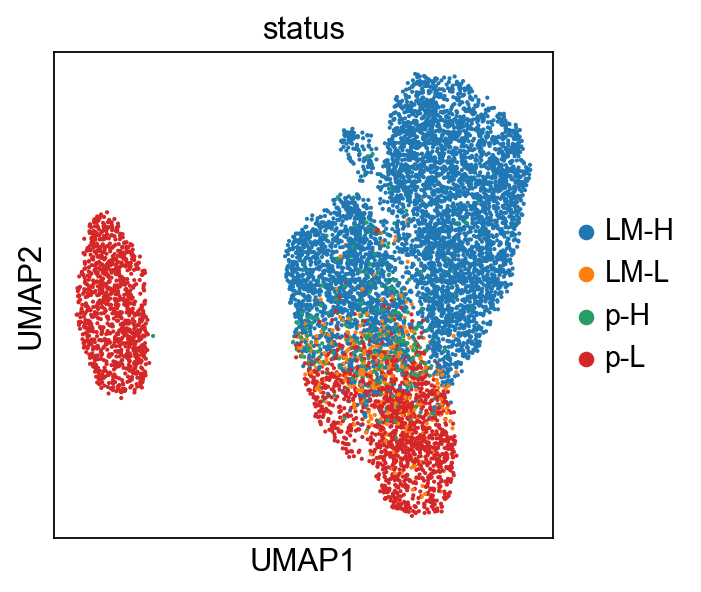

In [24]:
sc.pl.umap(adata, color=['status'])

Text(0.5, 0, 'Parental_Percent')

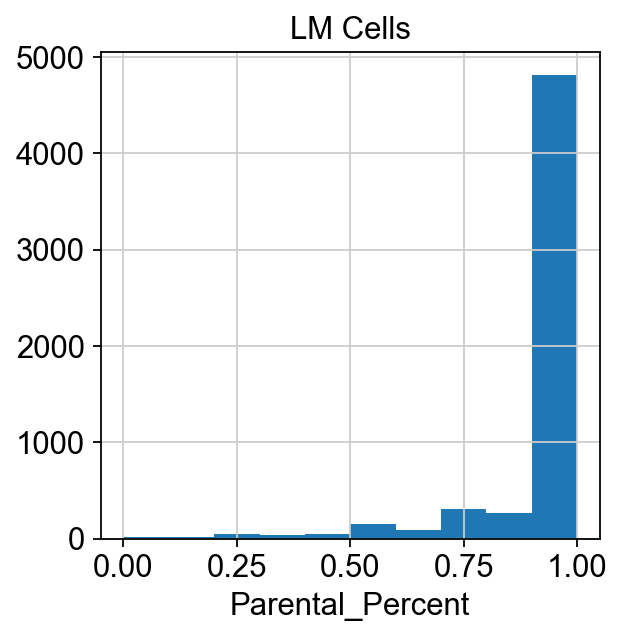

In [25]:
plt.hist(Parental_percent,bins = 10)
plt.title("LM Cells")
plt.xlabel("Parental_Percent")

Text(0.5, 0, 'LM_Percent')

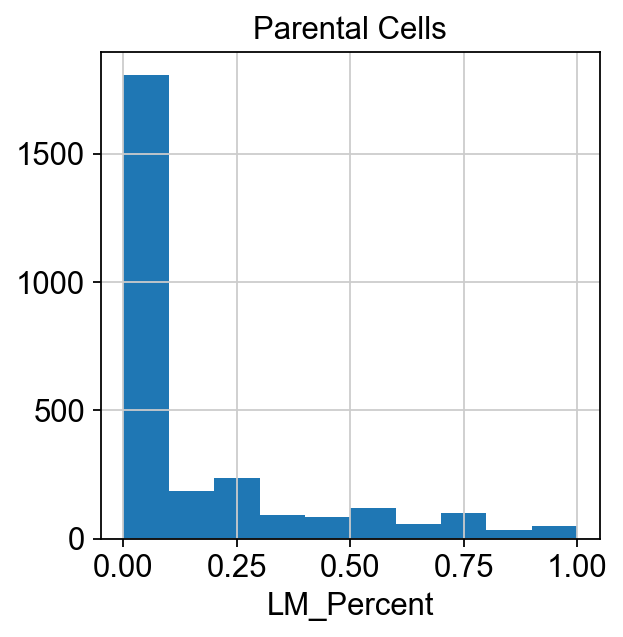

In [26]:
plt.hist(LM_percent,bins = 10)
plt.title("Parental Cells")
plt.xlabel("LM_Percent")

## Clustering the whole dataset

As Seurat and many others, we recommend the Leiden graph-clustering method (community detection based on optimizing modularity) by [Traag *et al.* (2018)](https://scanpy.readthedocs.io/en/latest/references.html#traag18). Note that Leiden clustering directly clusters the neighborhood graph of cells, which we already computed in the previous section.

In [40]:
sc.tl.leiden(adata)

running Leiden clustering
    finished: found 10 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:03)


Plot the clusters, which agree quite well with the result of Seurat.

In [41]:
x = adata.obs.groupby(by = ['leiden', 'SampleType']).size() / adata.obs.groupby(by = 'leiden').size()

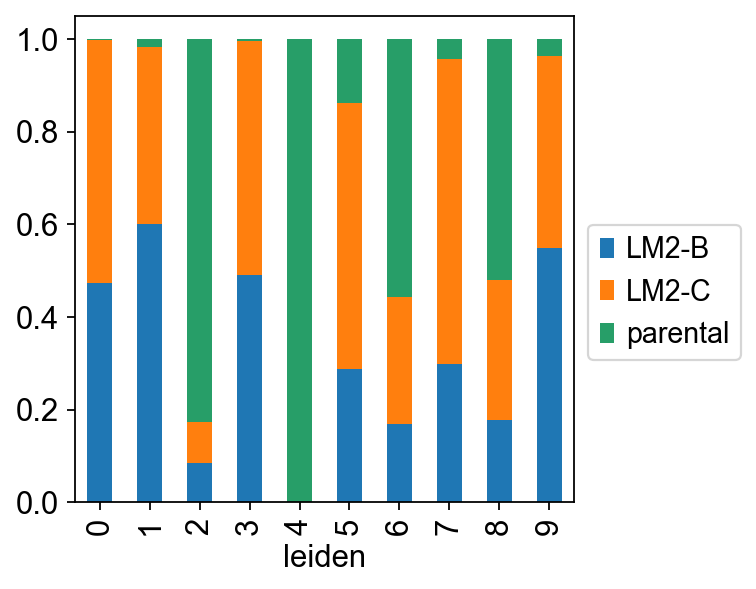

In [42]:
ax = x.unstack().plot(kind='bar', stacked = True)
ax.legend(bbox_to_anchor=(1, .6))
ax.grid(b=None)

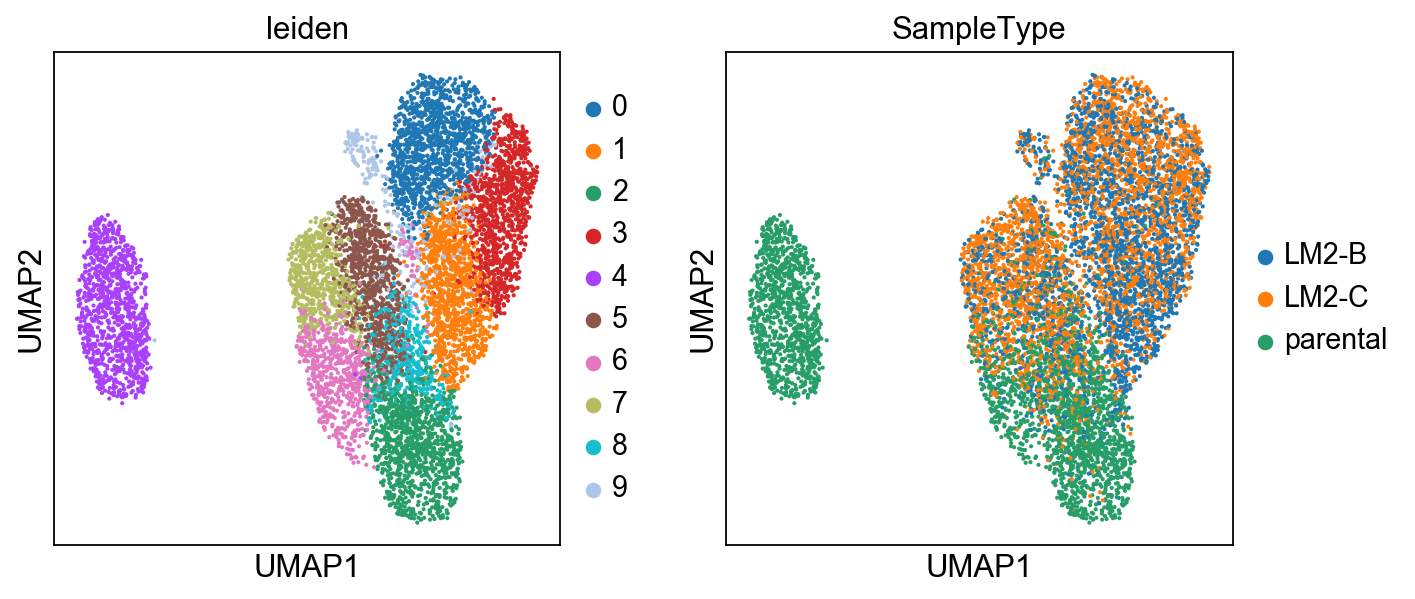

In [43]:
sc.pl.umap(adata, color=['leiden'])

Save the result.

In [44]:
adata.write(results_file)

## Incorporate clusteing results into metastatic status

In [45]:
mask1 = []
for num in adata.obs['leiden']:
    mask1.append(num)

In [46]:
mask2 = []
i = 0
for cell in adata.obs['status']:
    if cell.startswith('LM'):
        mask2.append(mask1[i])
    else:
        mask2.append(cell)
    i += 1

In [66]:
adata.obs['clustering'] = mask2

... storing 'clustering' as categorical


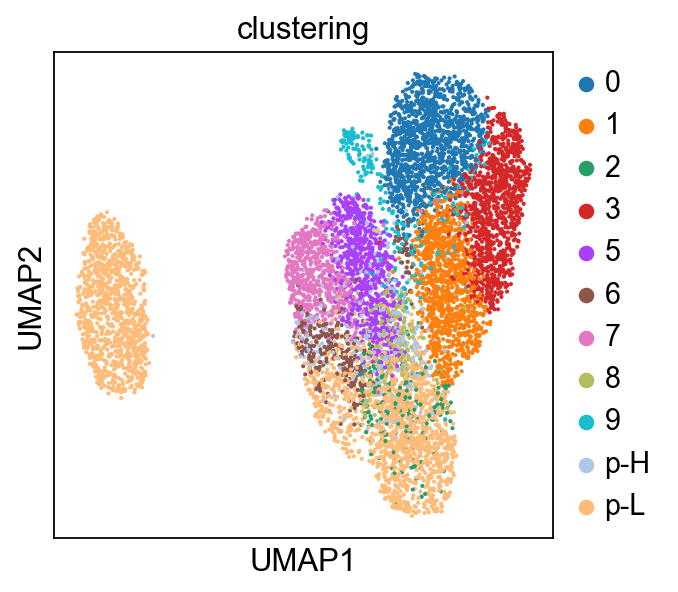

In [68]:
sc.pl.umap(adata, color=['clustering'] )

In [57]:
def DE_pairwise(adata, column,group, refer):
    plt.figure(figsize = (5,5))
    sc.tl.rank_genes_groups(adata, column, groups=[group], reference=refer, method='wilcoxon',n_genes = len(adata.var))
    fold_change = adata.uns['rank_genes_groups']['logfoldchanges'][group]
    gene_list = adata.uns['rank_genes_groups']['names'][group]
    pvals = adata.uns['rank_genes_groups']['pvals'][group]
    df1=pd.DataFrame(list(zip(gene_list,fold_change,pvals)),columns = ['genes','logfoldchange','pvals'])
    df1 = df1[df1.pvals<0.05]
    df1= df1.sort_values('logfoldchange',ascending=False)
    df1.index = range(len(df1))
    result = pd.DataFrame()
    for i in range(len(df1)):
        x = df1['logfoldchange'][i]
        y = - np.log10(df1.pvals)[i]
        if x > 1 or x < -1:
            plt.scatter(x, y, marker='x', color='red')
            result = result.append(df1.iloc[i][:])
            if x>=4 or x <=-4:
                plt.text(x, y+0.2, df1.genes[i], fontsize=9)
        else:
            plt.scatter(x, y,color = 'blue',alpha = 0.5,s= 6)        
    plt.xlabel('log2 fold change')
    plt.ylabel('-log10(p value)')
    plt.title(group + ' vs '+ refer)
    plt.savefig('/Users/student/Desktop/BP205B/DE/HCC_MK/pairwise/'+group+'_vs_'+refer)
    result.to_csv('/Users/student/Desktop/BP205B/DE/HCC_MK/pairwise/'+group+'_vs_'+refer+'.csv')

In [63]:
def DE_rest(adata,column):
    print(set(adata.obs[column]))
    sc.tl.rank_genes_groups(adata, column, method='wilcoxon',n_genes = len(adata.var))
    for group in set(adata.obs[column]):
        plt.figure(figsize = (5,5))
        fold_change = adata.uns['rank_genes_groups']['logfoldchanges'][group]
        gene_list = adata.uns['rank_genes_groups']['names'][group]
        pvals = adata.uns['rank_genes_groups']['pvals'][group]
        df1=pd.DataFrame(list(zip(gene_list,fold_change,pvals)),columns = ['genes','logfoldchange','pvals'])
        df1 = df1[df1.pvals<0.05]
        df1= df1.sort_values('logfoldchange',ascending=False)
        df1.index = range(len(df1))
        result = pd.DataFrame()
        for i in range(len(df1)):
            x = df1['logfoldchange'][i]
            y = - np.log10(df1.pvals)[i]
            if x > 1 or x < -1:
                plt.scatter(x, y, marker='x', color='red')
                result = result.append(df1.iloc[i][:])
                if x>=4 or x <=-4:
                    plt.text(x, y+0.2, df1.genes[i], fontsize=9)
            else:
                plt.scatter(x, y,color = 'blue',alpha = 0.5,s= 6)        
        plt.xlabel('log2 fold change')
        plt.ylabel('-log10(p value)')
        plt.title(group + ' vs rest')
        plt.savefig('/Users/student/Desktop/BP205B/DE/HCC_MK/VS_rest/'+group+'_vs_rest')
        result.to_csv('/Users/student/Desktop/BP205B/DE/HCC_MK/VS_rest/'+group+'_vs_rest.csv')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:05)


/usr/local/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:04)


/usr/local/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:04)


/usr/local/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:04)
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:03)
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be i

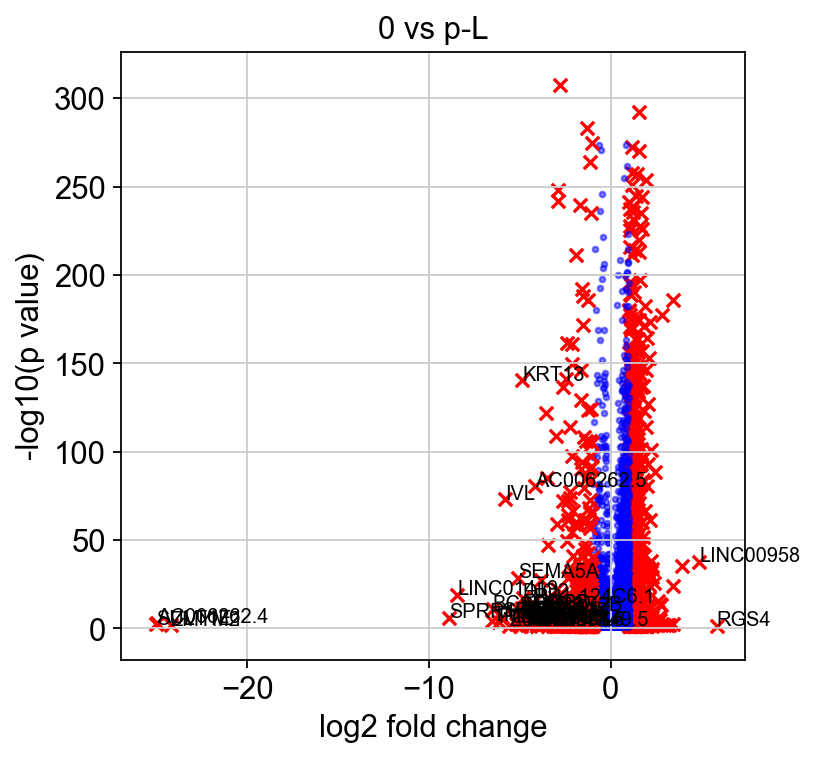

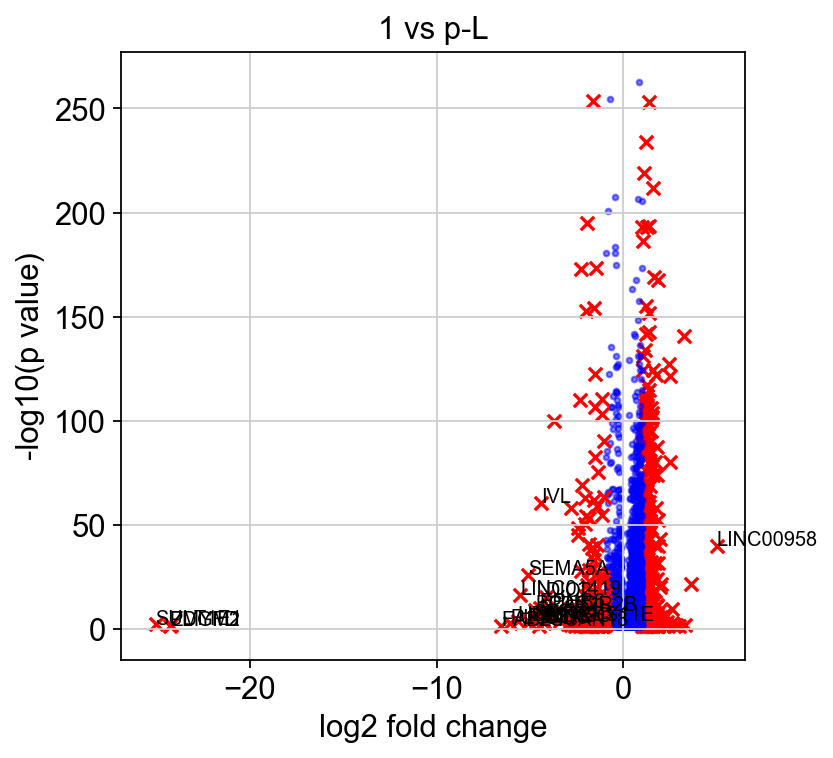

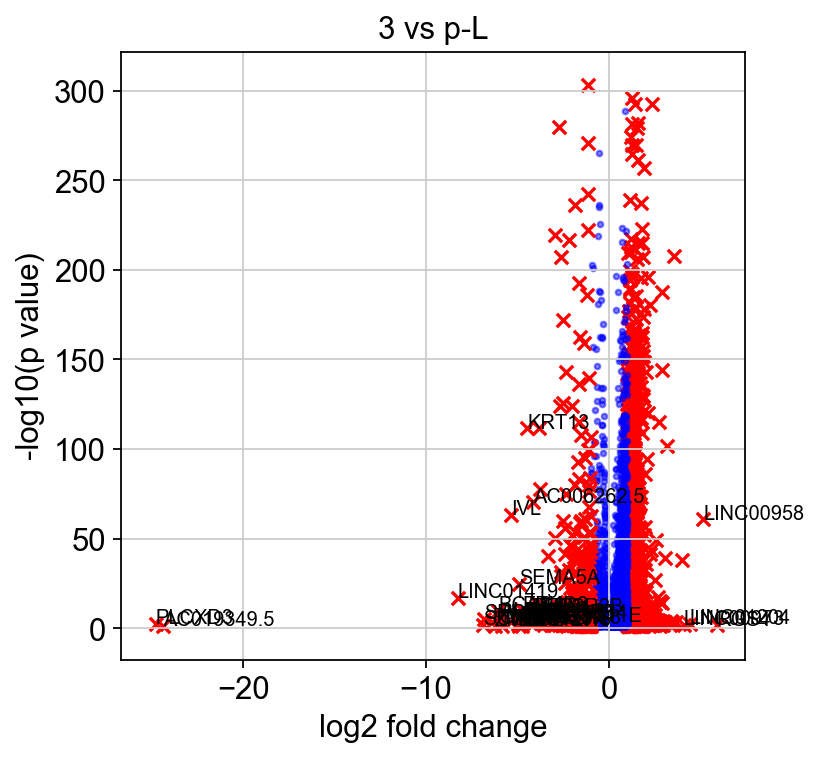

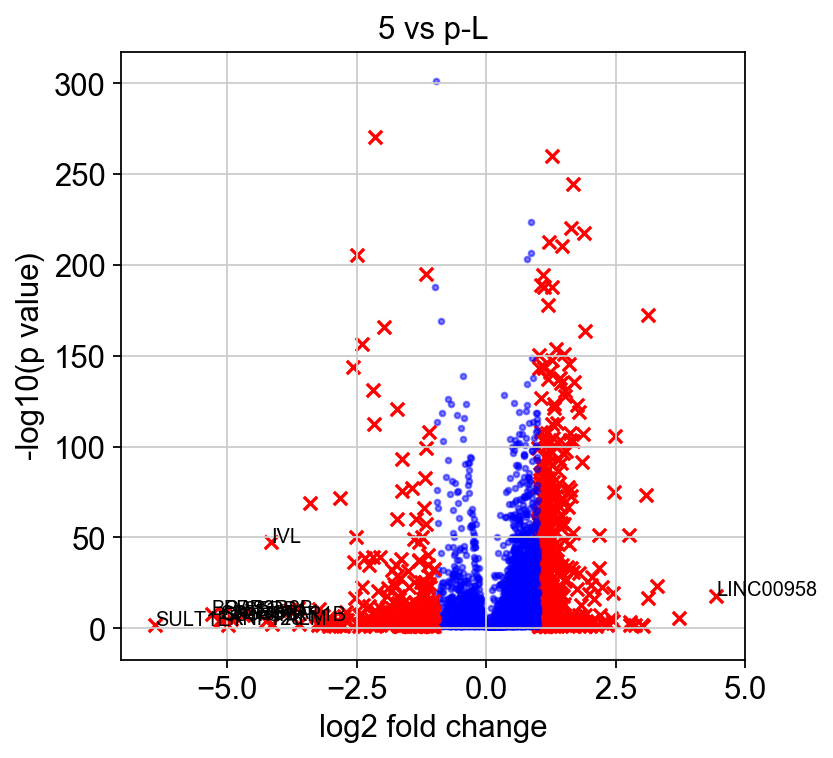

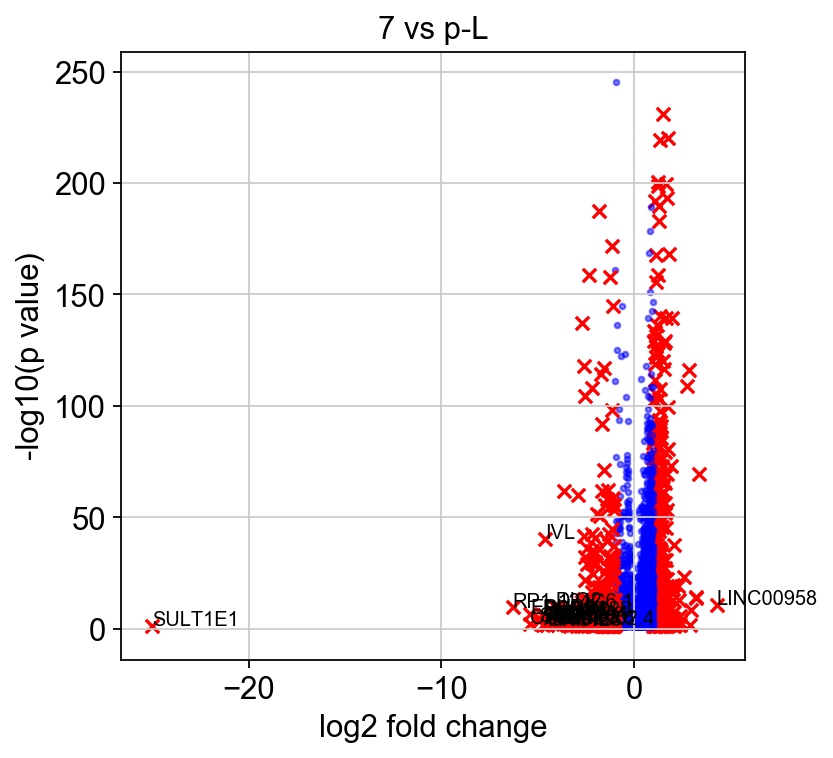

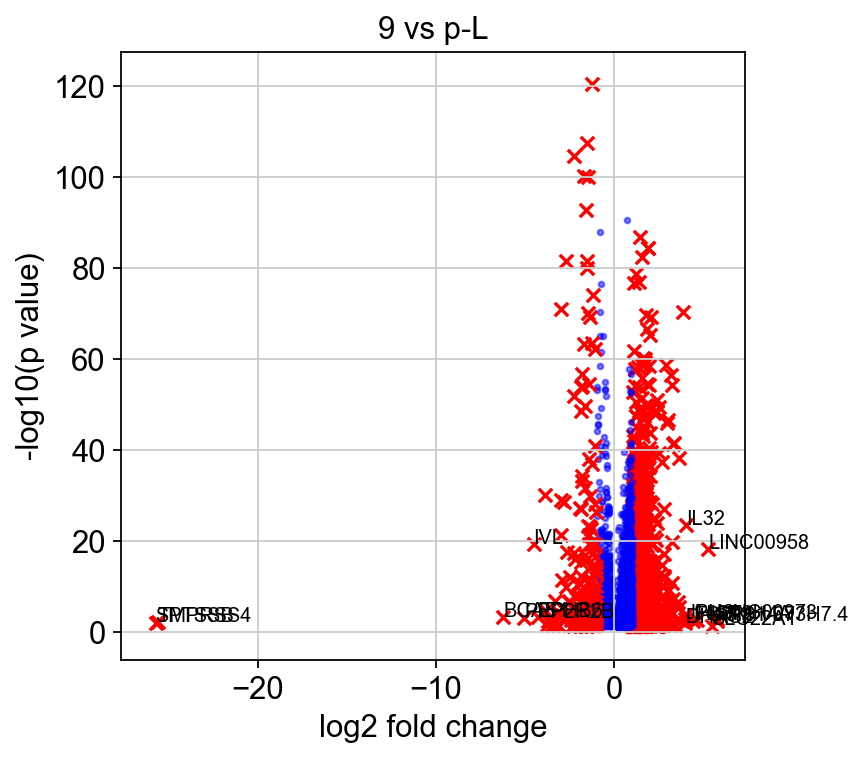

In [58]:
for i in ['0','1','3','5','7','9']:
    DE_pairwise(adata,'clustering',i,'p-L')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:12)


/usr/local/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


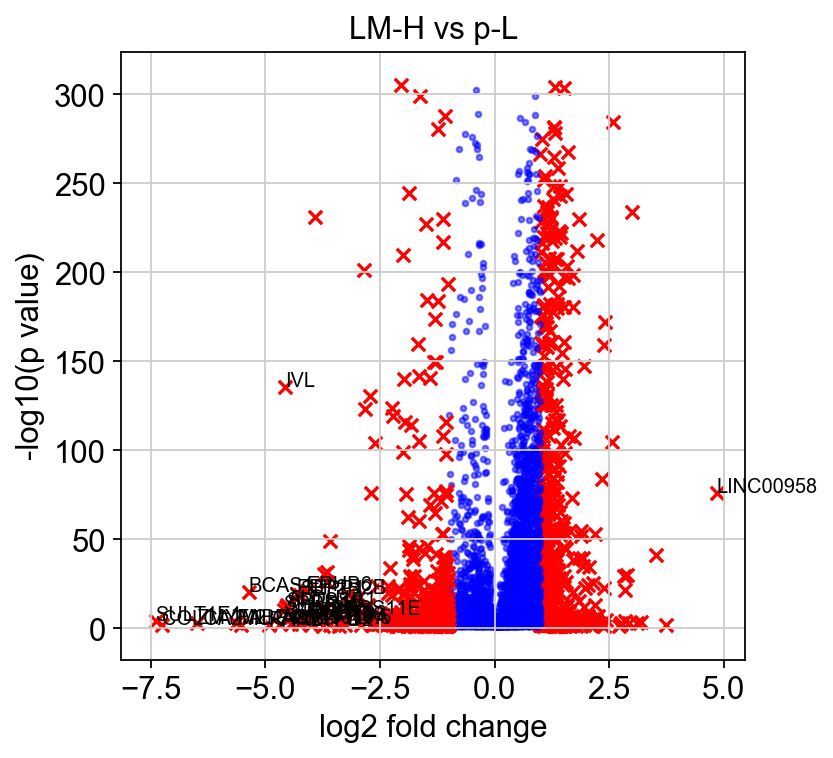

In [65]:
DE_pairwise(adata,'status','LM-H','p-L')

{'LM-H', 'p-H', 'LM-L', 'p-L'}
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:12)


/usr/local/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


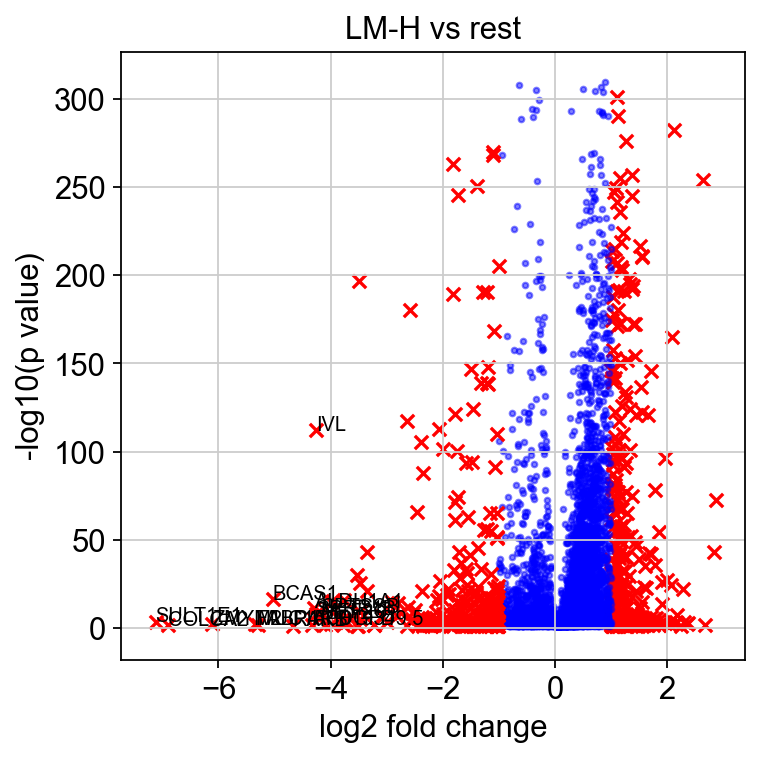

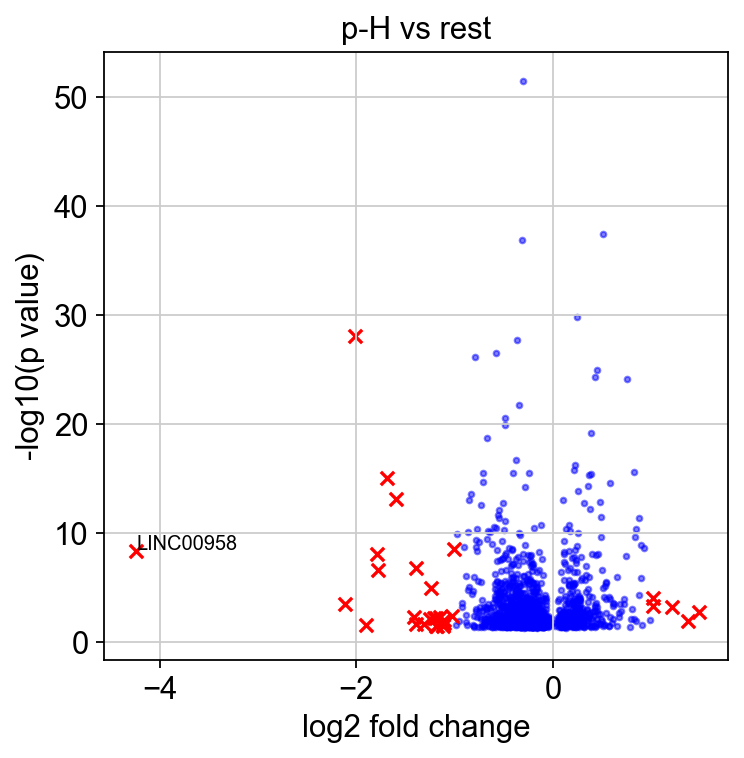

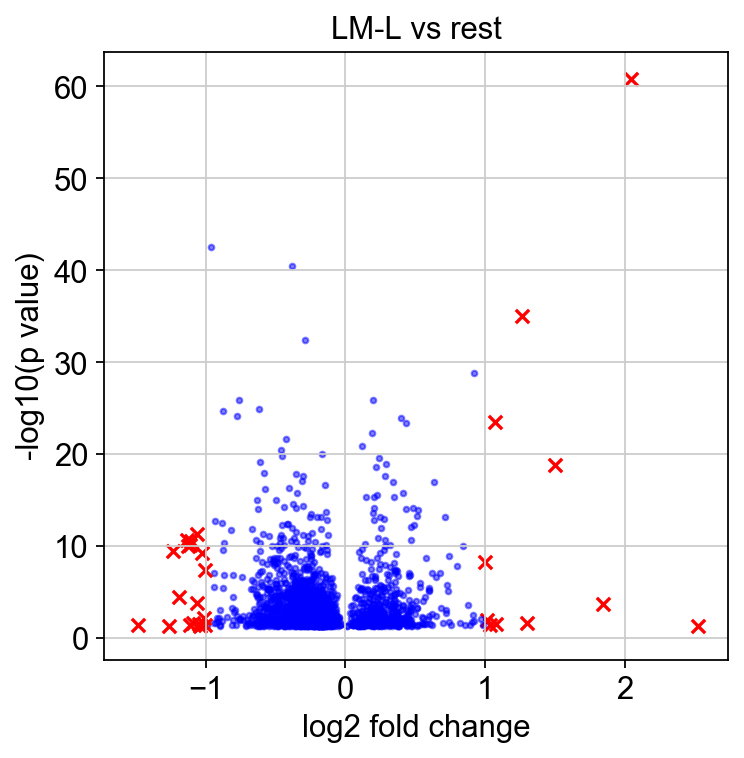

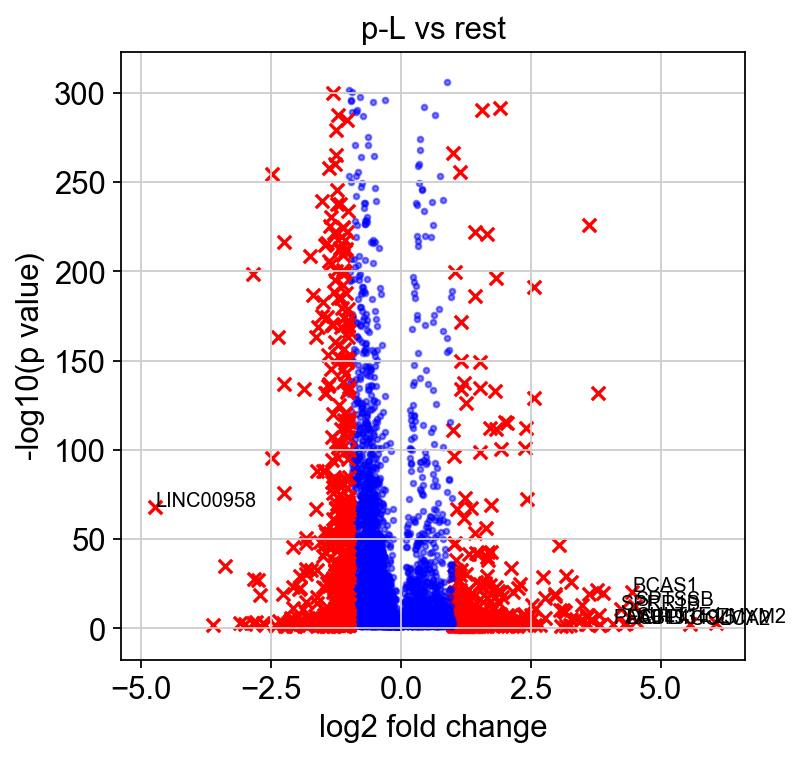

In [64]:
DE_rest(adata,'status')

Get a rough overview of the file using `h5ls`, which has many options - for more details see [here](https://github.com/theislab/scanpy_usage/blob/master/170505_seurat/info_h5ad.md). The file format might still be subject to further optimization in the future. All reading functions will remain backwards-compatible, though.

If you want to share this file with people who merely want to use it for visualization, a simple way to reduce the file size is by removing the dense scaled and corrected data matrix. The file still contains the raw data used in the visualizations.